# Artificial Neural Networks and Deep Learning - Homework 1















- Team: Bio.log(y)







- Members: Luca Lepore, Arianna Rigamonti, Michele Sala, Jacopo Libero Tettamanti















---















## ConvNeXtBase on pre-processed data

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024 - 2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024 - 2025] AN2DL/Homework 1


### ⚙️ Import Libraries

In [ ]:
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0


In [ ]:
!pip install tensorflow==2.17.0 keras==3.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.9 MB/s eta 0:00:00


In [ ]:
!pip install keras-cv --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.0 MB/s eta 0:00:00


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
import keras_cv.layers as cv_layers

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

# Import other libraries
import cv2
from keras.applications import ConvNeXtBase
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from ipywidgets import interact, IntSlider, Dropdown
from tensorflow.keras.utils import to_categorical
import plotly.express as px
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

TensorFlow version: 2.17.0
Keras version: 3.4.1


## ⏳ Load Data

In [ ]:
# Load your dataset
train_augmented = np.load('X_train_augmented_3x.npz')
X_train = train_augmented['images']
y_train = train_augmented['labels']

val_augmented = np.load('X_val_augmented_3x.npz')
X_val = val_augmented['images']
y_val = val_augmented['labels']

test = np.load('X_test.npz')
X_test = test['images']
y_test = test['labels']

test_augmented = np.load('X_test_augmented_4x.npz')
X_test_augmented = test_augmented['images']
y_test_augmented = test_augmented['labels']

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Save unique labels
unique_labels = list(labels.values())
print(f'Unique labels: {unique_labels}')

Unique labels: ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [ ]:
# Check the shape of the loaded images
print(f"Loaded X_train images shape: {X_train.shape}")
print(f"Loaded y_train labels shape: {y_train.shape}")
print(f"Min value X_train: {X_train.min()}, Max value X_train: {X_train.max()}\n")

print(f"Loaded X_val images shape: {X_val.shape}")
print(f"Loaded y_val labels shape: {y_val.shape}")
print(f"Min value X_val: {X_val.min()}, Max value X_val: {X_val.max()}\n")

print(f"Loaded X_test images shape: {X_test.shape}")
print(f"Loaded y_test labels shape: {y_test.shape}")
print(f"Min value X_test: {X_test.min()}, Max value X_test: {X_test.max()}\n")

print(f"Loaded X_test_augmented images shape: {X_test_augmented.shape}")
print(f"Loaded y_test_augmented labels shape: {y_test_augmented.shape}")
print(f"Min value X_test_augmented: {X_test_augmented.min()}, Max value X_test_augmented: {X_test_augmented.max()}")

Loaded X_train images shape: (21513, 96, 96, 3)
Loaded y_train labels shape: (21513, 8)
Min value X_train: 0.0, Max value X_train: 255.0

Loaded X_val images shape: (7173, 96, 96, 3)
Loaded y_val labels shape: (7173, 8)
Min value X_val: 0.0, Max value X_val: 255.0

Loaded X_test images shape: (2391, 96, 96, 3)
Loaded y_test labels shape: (2391, 8)
Min value X_test: 0, Max value X_test: 255

Loaded X_test_augmented images shape: (9564, 96, 96, 3)
Loaded y_test_augmented labels shape: (9564, 8)
Min value X_test_augmented: 0.0, Max value X_test_augmented: 255.0


## 🔎 Inspect Data

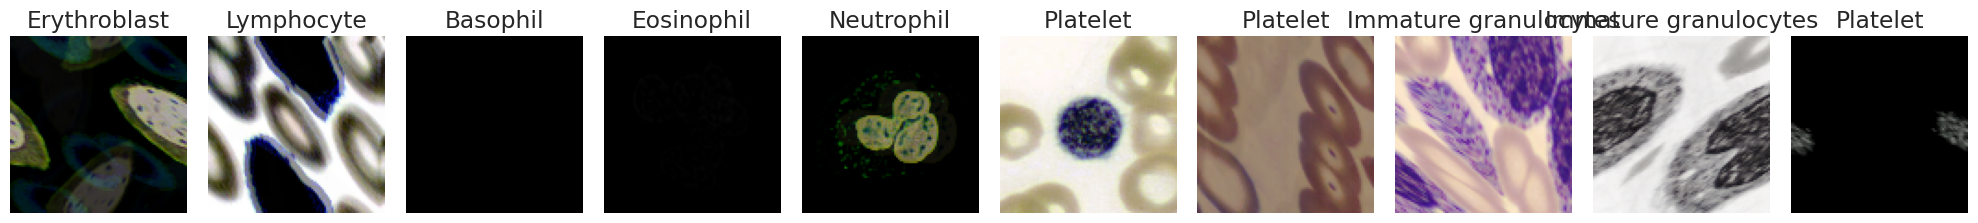

In [ ]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_train)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_train[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_train[idx])
    label = labels[label_index]

    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

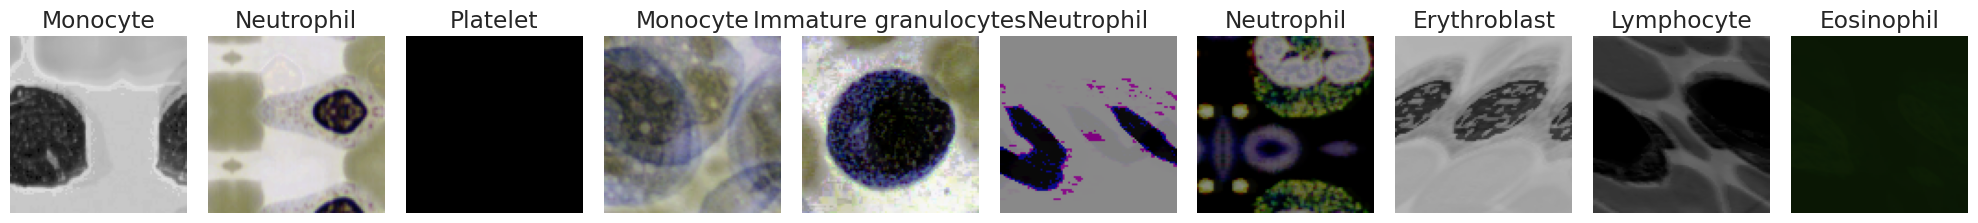

In [ ]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_val)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_val[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_val[idx])
    label = labels[label_index]
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

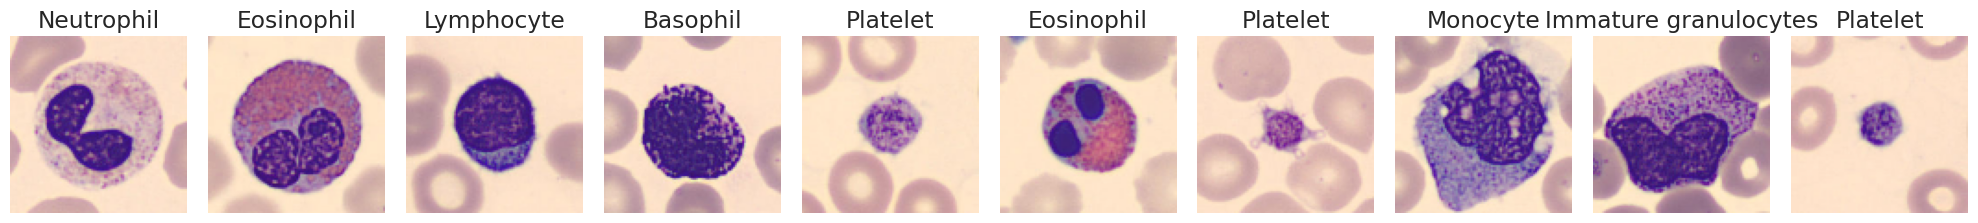

In [ ]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_test)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_test[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_test[idx])
    label = labels[label_index]
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

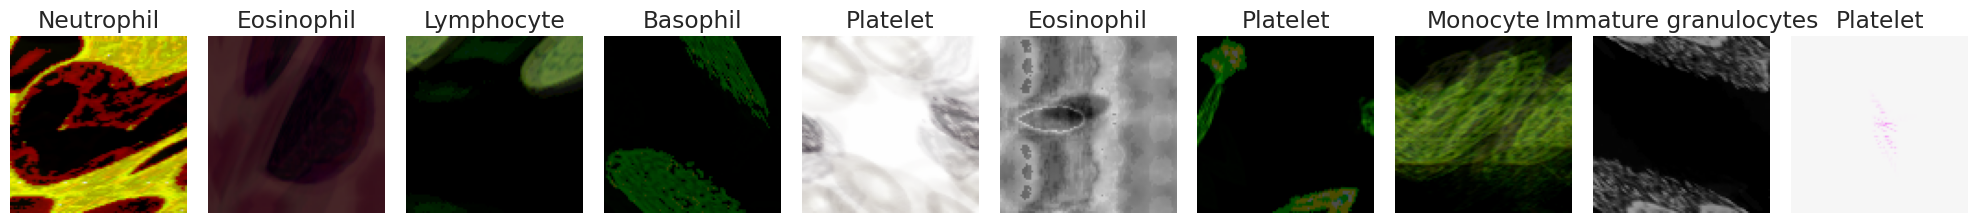

In [ ]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_test_augmented)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_test_augmented[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_test_augmented[idx])
    label = labels[label_index]
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Class balancing

In [ ]:
# Flatten the labels to class indices since they're in one-hot encoding
y_train_flat = np.argmax(y_train, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class weights:")
for class_index, weight in class_weight_dict.items():
    print(f"Class {class_index}: Weight {weight:.2f}")

Class weights:
Class 0: Weight 1.75
Class 1: Weight 0.69
Class 2: Weight 1.38
Class 3: Weight 0.74
Class 4: Weight 1.76
Class 5: Weight 1.50
Class 6: Weight 0.64
Class 7: Weight 0.91


## 🧮 Define Network Parameters

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 64

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 64


## **Inverted Residual Bottleneck with SE (MobileNetV3, 2019)**















<img src="https://www.researchgate.net/publication/378806327/figure/fig5/AS:11431281232045939@1711587010842/MobileNetV3-network-structure.jpg" width="600"/>























---







**Key Features and Achievements**























*   Pioneered platform-aware Neural Architecture Search (NAS)







*   Introduced hardware-aware network design







*   Combined manual design with automated search







*   Optimized for mobile inference latency















**Key building block:**















*   "Enhanced" Inverted Residual Block (Expansion ratio tuned per block, SE module redesigned for efficiency, Hard-Swish activation function(h-swish))







*   Efficient last stage design (Reduced channels in first layer, moved SE to cheaper layers, platform-aware operator selection)















**Impact:**















*   Set new SOTA for mobile networks







*   Demonstrated successful NAS and human design fusion







*   Showed importance of hardware-aware architecture design







*   Influenced automated architecture search methods















**📜 Paper:** ["Searching for MobileNetV3", Howard et al.](https://arxiv.org/pdf/1905.02244)















---















<img src="https://drive.google.com/uc?export=view&id=1EcBp60nEorTDLROT_1L4a4Mvw9kLdKqd" width="300"/>

## 🛠️ Transfer Learning















<img src="https://radekosmulski.com/content/images/2021/08/imagenet_banner.jpeg" width="700"/>

In [ ]:
# Initialise ConvNeXtBase model with pretrained weights, for transfer learning

mymodel = tf.keras.applications.ConvNeXtBase(
        include_top = False,
        include_preprocessing = True,
        weights = "imagenet",
        input_shape = input_shape,
        pooling = "avg",
    )

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Display a summary of the model architecture
mymodel.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(mymodel, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

#### Model with 1 dense layer

In [ ]:
# Freeze all layers in ConvNeXtBase to use it solely as a feature extractor
mymodel.trainable = False  # Freeze pretrained weights

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the MobileNetV3Small feature extractor
x = mymodel(inputs)
print("Shape after ConvNeXtBase:", x.shape)

# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)
print("Shape after Dropout1:", x.shape)

# Add a final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense1')(x)
print("Shape after Dense1:", outputs.shape)

# Define the complete model linking input and output
tl_model1 = tfk.Model(inputs=inputs, outputs=outputs, name='model1')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model1.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])  # default learning rate = 0.001

Shape after ConvNeXtBase: (None, 1024)
Shape after Dropout1: (None, 1024)
Shape after Dense1: (None, 8)


In [ ]:
# Display a summary of the model architecture
tl_model1.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model1, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

#### Model with 2 dense layer

In [ ]:
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mymodel.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the MobileNetV3Small feature extractor
x = mymodel(inputs)
print("Shape after MobileNetV3Small:", x.shape)

# Add a Dense layer without activation
x = tfkl.Dense(512, name='dense1')(x)
print("Shape after Dense1:", x.shape)

# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm1')(x)
print("Shape after BatchNorm1:", x.shape)

# Add ReLU activation
x = tfkl.Activation('relu', name='activation1')(x)
print("Shape after Activation1:", x.shape)

# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)
print("Shape after Dropout1:", x.shape)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense3')(x)
print("Shape after Dense3:", outputs.shape)

# Define the complete model linking input and output
tl_model2 = tfk.Model(inputs=inputs, outputs=outputs, name='model2')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])  # default learning rate = 0.001

Shape after MobileNetV3Small: (None, 1024)
Shape after Dense1: (None, 512)
Shape after BatchNorm1: (None, 512)
Shape after Activation1: (None, 512)
Shape after Dropout1: (None, 512)
Shape after Dense3: (None, 8)


In [ ]:
# Display a summary of the model architecture
tl_model2.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

#### Model with 3 dense layers

In [ ]:
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mymodel.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the MobileNetV3Small feature extractor
x = mymodel(inputs)
print("Shape after ConvNeXtBase:", x.shape)

# Add a Dense layer without activation
x = tfkl.Dense(512, name='dense1')(x)
print("Shape after Dense1:", x.shape)

# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm1')(x)
print("Shape after BatchNorm1:", x.shape)

# Add ReLU activation
x = tfkl.Activation('relu', name='activation1')(x)
print("Shape after Activation1:", x.shape)

# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)
print("Shape after Dropout1:", x.shape)

# Add another Dense layer without activation
x = tfkl.Dense(256, name='dense2')(x)
print("Shape after Dense2:", x.shape)

# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm2')(x)
print("Shape after BatchNorm2:", x.shape)

# Add ReLU activation
x = tfkl.Activation('relu', name='activation2')(x)
print("Shape after Activation2:", x.shape)

# Add another Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout2')(x)
print("Shape after Dropout2:", x.shape)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense3')(x)
print("Shape after Dense3:", outputs.shape)

# Define the complete model linking input and output
tl_model3 = tfk.Model(inputs=inputs, outputs=outputs, name='model3')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])  # default learning rate = 0.001

Shape after ConvNeXtBase: (None, 1024)
Shape after Dense1: (None, 512)
Shape after BatchNorm1: (None, 512)
Shape after Activation1: (None, 512)
Shape after Dropout1: (None, 512)
Shape after Dense2: (None, 256)
Shape after BatchNorm2: (None, 256)
Shape after Activation2: (None, 256)
Shape after Dropout2: (None, 256)
Shape after Dense3: (None, 8)


In [ ]:
# Display a summary of the model architecture
tl_model3.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model3, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Metric to monitor
    mode='max',                   # Mode ('max' for accuracy)
    patience=20,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True     # Restore the model weights from the epoch with the best value of the monitored metric
)

In [ ]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Metric to monitor
    factor=0.5,                   # Factor by which the learning rate will be reduced
    patience=5,                   # Number of epochs with no improvement before reducing learning rate
    verbose=1,                    # Verbosity mode (0 = silent, 1 = updates messages)
    min_lr=1e-6                   # Lower bound on the learning rate
)

In [ ]:
# Train the model 1
tl_history1 = tl_model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy1 = round(max(tl_history1['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 1: {final_val_accuracy1}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'ConvNeXtBase1_{final_val_accuracy1}.keras'
tl_model1.save(model_filename)

# Free memory by deleting the model instance
del tl_model1

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.4126 - loss: 1.7590 - val_accuracy: 0.6784 - val_loss: 0.9407 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6247 - loss: 1.0861 - val_accuracy: 0.7090 - val_loss: 0.8455 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6657 - loss: 0.9782 - val_accuracy: 0.7281 - val_loss: 0.7937 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6773 - loss: 0.9461 - val_accuracy: 0.7353 - val_loss: 0.7701 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6816 - loss: 0.9131 - val_accuracy: 0.7358 - val_loss: 0.7648 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6921 - loss: 0.8977 - val_accuracy: 0.7447 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.

In [ ]:
# Train the model 2
tl_history2 = tl_model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy2 = round(max(tl_history2['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 2: {final_val_accuracy2}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'ConvNeXtBase2_{final_val_accuracy2}.keras'
tl_model2.save(model_filename)

# Free memory by deleting the model instance
del tl_model2

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.5513 - loss: 1.3068 - val_accuracy: 0.7157 - val_loss: 0.8134 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7273 - loss: 0.7698 - val_accuracy: 0.7390 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7737 - loss: 0.6339 - val_accuracy: 0.7478 - val_loss: 0.7347 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.8049 - loss: 0.5520 - val_accuracy: 0.7531 - val_loss: 0.7338 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.8313 - loss: 0.4740 - val_accuracy: 0.7552 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8545 - loss: 0.4137 - val_accuracy: 0.7627 - val_loss: 0.7398 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.8

In [ ]:
# Train the model 3
tl_history3 = tl_model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy3 = round(max(tl_history3['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3: {final_val_accuracy3}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'ConvNeXtBase3_{final_val_accuracy3}.keras'
tl_model3.save(model_filename)

# Free memory by deleting the model instance
del tl_model3

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.5053 - loss: 1.4249 - val_accuracy: 0.7132 - val_loss: 0.8107 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.6924 - loss: 0.8779 - val_accuracy: 0.7273 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7376 - loss: 0.7391 - val_accuracy: 0.7464 - val_loss: 0.7303 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7650 - loss: 0.6529 - val_accuracy: 0.7513 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.7914 - loss: 0.5780 - val_accuracy: 0.7559 - val_loss: 0.7125 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8044 - loss: 0.5227 - val_accuracy: 0.7404 - val_loss: 0.7814 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.

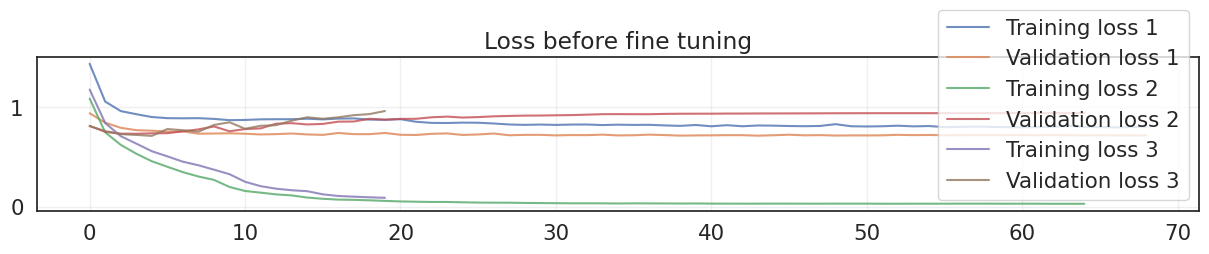

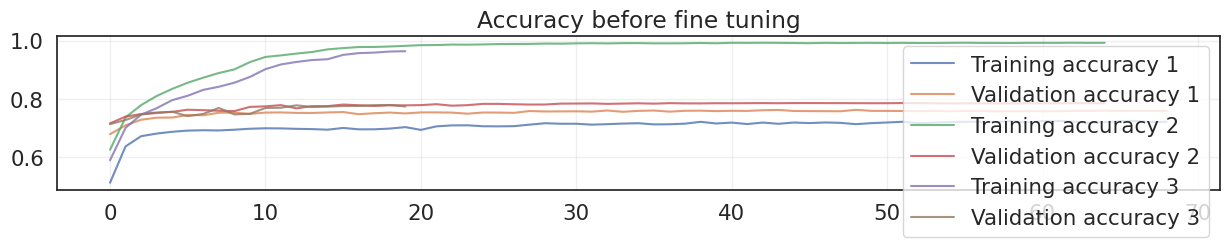

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(tl_history1['loss'], label='Training loss 1', alpha=.8)
plt.plot(tl_history1['val_loss'], label='Validation loss 1', alpha=.8)
plt.plot(tl_history2['loss'], label='Training loss 2', alpha=.8)
plt.plot(tl_history2['val_loss'], label='Validation loss 2', alpha=.8)
plt.plot(tl_history3['loss'], label='Training loss 3', alpha=.8)
plt.plot(tl_history3['val_loss'], label='Validation loss 3', alpha=.8)
plt.title('Loss before fine tuning')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(tl_history1['accuracy'], label='Training accuracy 1', alpha=.8)
plt.plot(tl_history1['val_accuracy'], label='Validation accuracy 1', alpha=.8)
plt.plot(tl_history2['accuracy'], label='Training accuracy 2', alpha=.8)
plt.plot(tl_history2['val_accuracy'], label='Validation accuracy 2', alpha=.8)
plt.plot(tl_history3['accuracy'], label='Training accuracy 3', alpha=.8)
plt.plot(tl_history3['val_accuracy'], label='Validation accuracy 3', alpha=.8)
plt.title('Accuracy before fine tuning')
plt.legend()
plt.grid(alpha=.3)

plt.show()

## 🛠️ Fine Tuning















<img src="https://www.researchgate.net/publication/359405075/figure/fig2/AS:1182999492214798@1659060466845/Concept-of-fine-tuning-and-feature-extraction_W640.jpg" width="700"/>


In [ ]:
# Re-load the model after transfer learning
ft_model1 = tfk.models.load_model('ConvNeXtBase1_76.23.keras') # model 1
ft_model2 = tfk.models.load_model('ConvNeXtBase2_78.57.keras') # model 2
ft_model3 = tfk.models.load_model('ConvNeXtBase3_77.92.keras') # model 3

In [ ]:
# Set the MobileNetV3Small model layers as trainable
ft_model1.get_layer('convnext_base').trainable = True
ft_model2.get_layer('convnext_base').trainable = True
ft_model3.get_layer('convnext_base').trainable = True

In [ ]:
# Unfreeze the layers in the last two stages
trainable = False

for layer in ft_model1.get_layer('convnext_base').layers:
    if "stage_2" in layer.name or "stage_3" in layer.name:
        trainable = True
    layer.trainable = trainable

# Set the BatchNorm layers as non-trainable
for layer in ft_model1.get_layer('convnext_base').layers:
    if isinstance(layer, tf.keras.layers.LayerNormalization):
        layer.trainable = False

# Unfreeze the layers in the last two stages
trainable = False

for layer in ft_model2.get_layer('convnext_base').layers:
    if "stage_2" in layer.name or "stage_3" in layer.name:
        trainable = True
    layer.trainable = trainable

# Set the BatchNorm layers as non-trainable
for layer in ft_model2.get_layer('convnext_base').layers:
    if isinstance(layer, tf.keras.layers.LayerNormalization):
        layer.trainable = False

# Unfreeze the layers in the last two stages
trainable = False

for layer in ft_model3.get_layer('convnext_base').layers:
    if "stage_2" in layer.name or "stage_3" in layer.name:
        trainable = True
    layer.trainable = trainable

# Set the BatchNorm layers as non-trainable
for layer in ft_model3.get_layer('convnext_base').layers:
    if isinstance(layer, tf.keras.layers.LayerNormalization):
        layer.trainable = False



# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model1.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

for i, layer in enumerate(ft_model2.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

for i, layer in enumerate(ft_model3.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 convnext_base_stage_0_block_1_depthwise_conv False
11 convnext_base_stage_0_block_1_layernorm False
12 convnext_base_stage_0_block_1_pointwise_conv_1 False
13 convnext_base_stage_0_block_1_gelu False
14 convnext_base_stage_0_block_1_pointwise_conv_2 False
15 convnext_base_stage_0_block_1_layer_scale False
16 convnext_base_stage_0_block_1_identity False
17 convnext_base_stage_0_block_2_depthwise_conv False
18 convnext_base_stage_0_block_2_layernorm False
19 convnext_base_stage_0_block_2_pointwise_conv_1 False
20 convnext_base_stage_0_block_2_gelu Fal

In [ ]:
# Display a summary of the model 1 architecture
ft_model1.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model1, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Display a summary of the model 2 architecture
ft_model2.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Display a summary of the model 3 architecture
ft_model3.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model3, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Compile the model
ft_model1.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])
ft_model2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])
ft_model3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
# Fine-tune the model 1
ft_history1 = ft_model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy1 = round(max(ft_history1['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 1: {final_val_accuracy1}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNeXtBase1_FT_' + str(final_val_accuracy1) + '.keras'
ft_model1.save(model_filename)

# Delete the model to free up resources
del ft_model1

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.7879 - loss: 0.6355 - val_accuracy: 0.8848 - val_loss: 0.3266 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.9326 - loss: 0.1857 - val_accuracy: 0.8861 - val_loss: 0.3917 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.9725 - loss: 0.0728 - val_accuracy: 0.8857 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.9801 - loss: 0.0573 - val_accuracy: 0.8832 - val_loss: 0.4942 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.9859 - loss: 0.0405 - val_accuracy: 0.8897 - val_loss: 0.4677 - learning_rate: 1.0000e-04
Epoch 6/200
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9901 - loss: 0.0262
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 1

In [ ]:
# Fine-tune the model 2
ft_history2 = ft_model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy2 = round(max(ft_history2['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 2: {final_val_accuracy2}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNeXtBase2_FT_' + str(final_val_accuracy2) + '.keras'
ft_model2.save(model_filename)

# Delete the model to free up resources
del ft_model2

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 119s 193ms/step - accuracy: 0.9219 - loss: 0.2333 - val_accuracy: 0.8317 - val_loss: 0.6617 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.9576 - loss: 0.1207 - val_accuracy: 0.8420 - val_loss: 0.5986 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.9798 - loss: 0.0485 - val_accuracy: 0.8479 - val_loss: 0.6377 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.9903 - loss: 0.0276 - val_accuracy: 0.8642 - val_loss: 0.5876 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.9926 - loss: 0.0218 - val_accuracy: 0.8578 - val_loss: 0.6128 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.9886 - loss: 0.0308 - val_accuracy: 0.8585 - val_loss: 0.6796 - learning_rate: 1.0000e-04
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Fine-tune the model 3
ft_history3 = ft_model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy3 = round(max(ft_history3['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3: {final_val_accuracy3}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNeXtBase3_FT_' + str(final_val_accuracy3) + '.keras'
ft_model3.save(model_filename)

# Delete the model to free up resources
del ft_model3

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - accuracy: 0.7905 - loss: 0.6128 - val_accuracy: 0.8724 - val_loss: 0.3589 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.9293 - loss: 0.2018 - val_accuracy: 0.8953 - val_loss: 0.3132 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.9783 - loss: 0.0691 - val_accuracy: 0.8959 - val_loss: 0.3766 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.9895 - loss: 0.0350 - val_accuracy: 0.8723 - val_loss: 0.5199 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.9891 - loss: 0.0372 - val_accuracy: 0.8920 - val_loss: 0.4323 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.9916 - loss: 0.0243 - val_accuracy: 0.8973 - val_loss: 0.4197 - learning_rate: 1.0000e-04
Epoch 7/200
336/337 ━━━━━━━━━━━━━━━━━━━

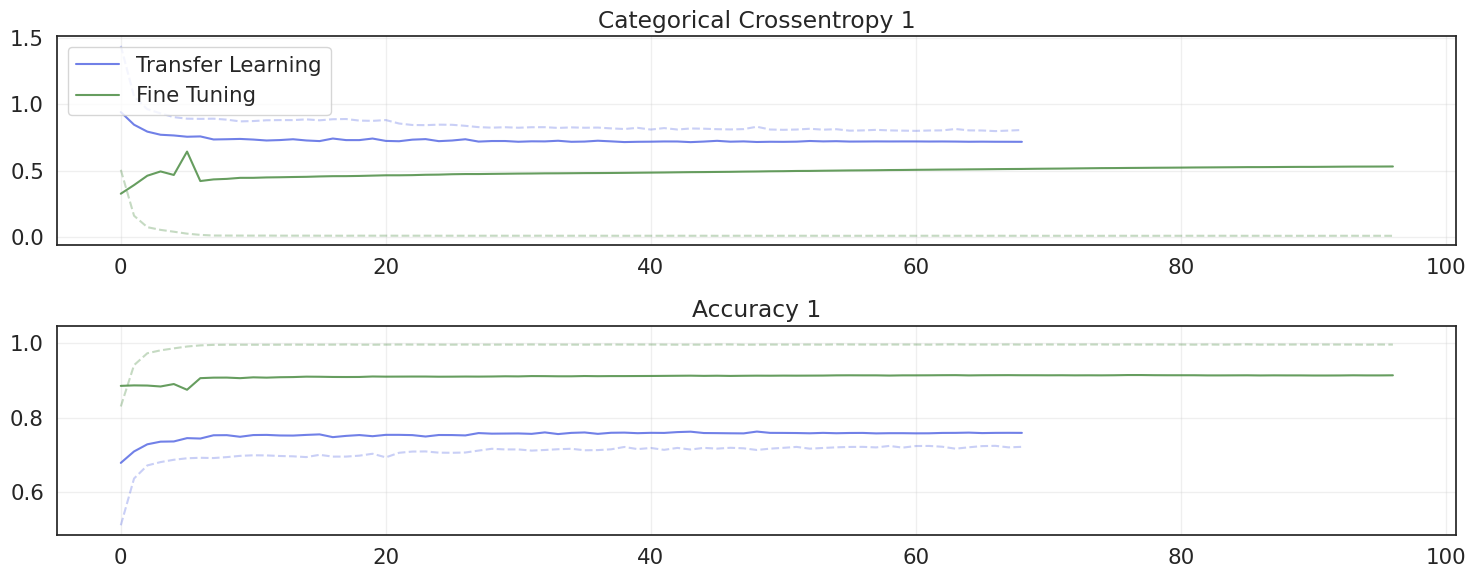

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history1['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history1['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history1['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history1['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy 1')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history1['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history1['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history1['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history1['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy 1')

# Dynamically calculate y-axis limits for accuracy
all_accuracies = (
    tl_history1['accuracy'] +
    tl_history1['val_accuracy'] +
    ft_history1['accuracy'] +
    ft_history1['val_accuracy']
)
ax2.set_ylim([min(all_accuracies) * 0.95, max(all_accuracies) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

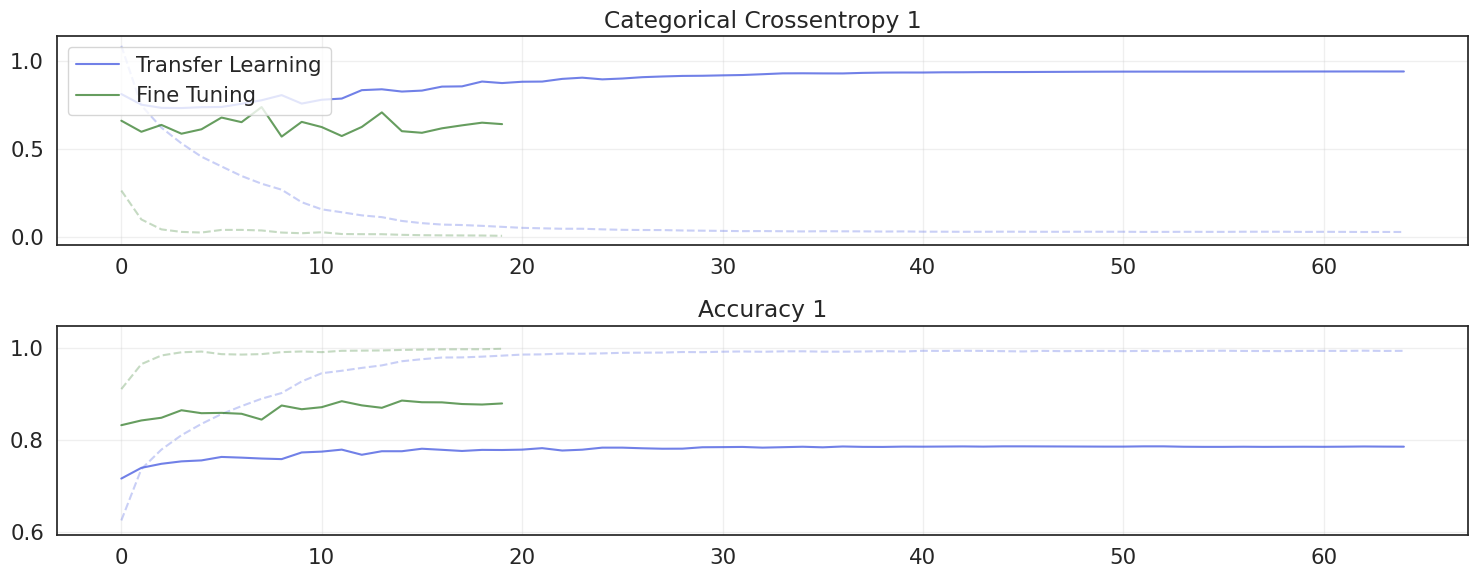

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history2['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history2['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history2['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history2['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy 1')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history2['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history2['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history2['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history2['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy 1')

# Dynamically calculate y-axis limits for accuracy
all_accuracies = (
    tl_history2['accuracy'] +
    tl_history2['val_accuracy'] +
    ft_history2['accuracy'] +
    ft_history2['val_accuracy']
)
ax2.set_ylim([min(all_accuracies) * 0.95, max(all_accuracies) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

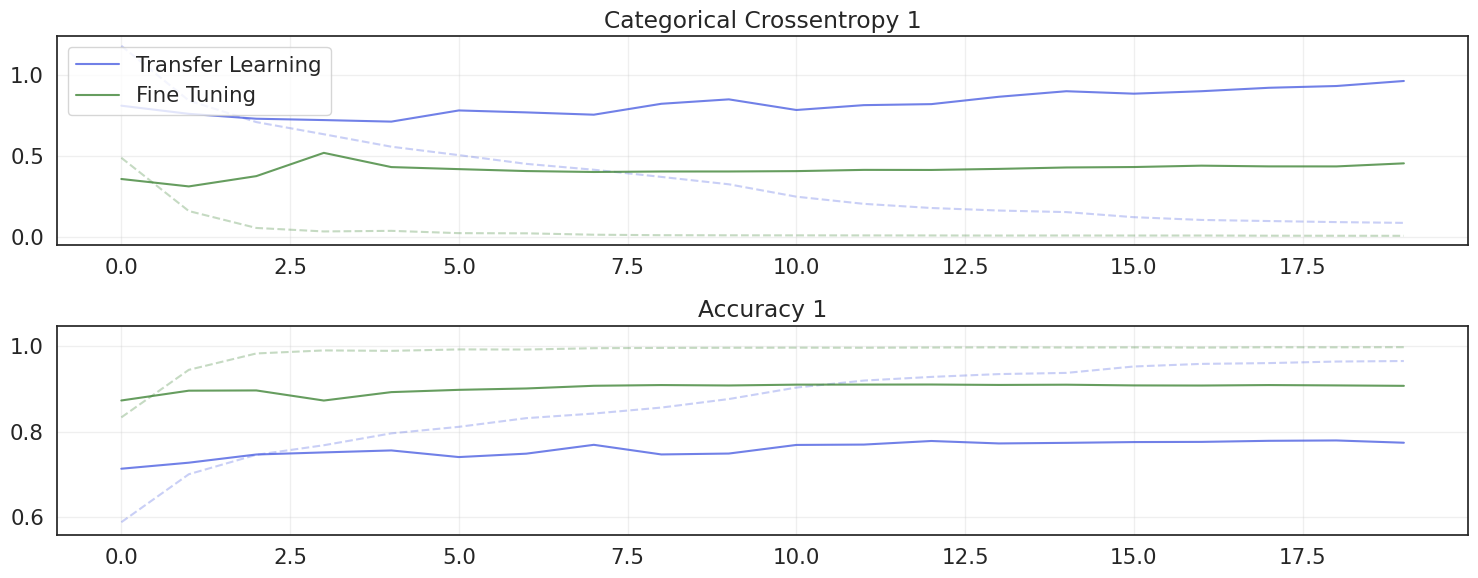

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history3['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history3['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history3['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history3['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy 1')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history3['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history3['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history3['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history3['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy 1')

# Dynamically calculate y-axis limits for accuracy
all_accuracies = (
    tl_history3['accuracy'] +
    tl_history3['val_accuracy'] +
    ft_history3['accuracy'] +
    ft_history3['val_accuracy']
)
ax2.set_ylim([min(all_accuracies) * 0.95, max(all_accuracies) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

## Final fine tuning
Unfreeze all layers

In [ ]:
# Re-load the model after first fine tuning
ft_full_model1 = tfk.models.load_model('ConvNeXtBase1_FT_91.38.keras')  # model 1

# Unfreeze all layers
for layer in ft_full_model1.get_layer('convnext_base').layers:
    layer.trainable = True

# Set the BatchNorm layers as non-trainable
for layer in ft_full_model1.get_layer('convnext_base').layers:
    if isinstance(layer, tf.keras.layers.LayerNormalization):
        layer.trainable = False

# Recompile the model
ft_full_model1.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training with full fine tuning
ft_history1_full = ft_full_model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy1_full = round(max(ft_history1_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 1 (full): {final_val_accuracy1_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNeXtBase1_FTfull_' + str(final_val_accuracy1_full) + '.keras'
ft_full_model1.save(model_filename)

# Delete the model to free up resources
del ft_full_model1

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 145s 243ms/step - accuracy: 0.9962 - loss: 0.0097 - val_accuracy: 0.9081 - val_loss: 0.5441 - learning_rate: 1.0000e-05
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 153ms/step - accuracy: 0.9954 - loss: 0.0095 - val_accuracy: 0.9115 - val_loss: 0.5357 - learning_rate: 1.0000e-05
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.9951 - loss: 0.0098 - val_accuracy: 0.9092 - val_loss: 0.5338 - learning_rate: 1.0000e-05
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9955 - loss: 0.0096 - val_accuracy: 0.9109 - val_loss: 0.5360 - learning_rate: 1.0000e-05
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9954 - loss: 0.0096 - val_accuracy: 0.9113 - val_loss: 0.5396 - learning_rate: 1.0000e-05
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9954 - loss: 0.0095 - val_accuracy: 0.9116 - val_loss: 0.5385 - learning_rate: 1.0000e-05
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Re-load the model after first fine tuning
ft_full_model2 = tfk.models.load_model('ConvNeXtBase2_FT_88.53.keras')  # model 2

# Unfreeze all layers
for layer in ft_full_model2.get_layer('convnext_base').layers:
    layer.trainable = True

# Set the BatchNorm layers as non-trainable
for layer in ft_full_model2.get_layer('convnext_base').layers:
    if isinstance(layer, tf.keras.layers.LayerNormalization):
        layer.trainable = False

# Recompile the model
ft_full_model2.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training with full fine tuning
ft_history2_full = ft_full_model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy2_full = round(max(ft_history2_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 2 (full): {final_val_accuracy2_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNeXtBase2_FTfull_' + str(final_val_accuracy2_full) + '.keras'
ft_full_model2.save(model_filename)

# Delete the model to free up resources
del ft_full_model2

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9632 - loss: 0.1050 - val_accuracy: 0.8504 - val_loss: 0.5651 - learning_rate: 1.0000e-05
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 153ms/step - accuracy: 0.9888 - loss: 0.0330 - val_accuracy: 0.8517 - val_loss: 0.5678 - learning_rate: 1.0000e-05
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.9935 - loss: 0.0222 - val_accuracy: 0.8542 - val_loss: 0.5702 - learning_rate: 1.0000e-05
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9950 - loss: 0.0177 - val_accuracy: 0.8545 - val_loss: 0.5778 - learning_rate: 1.0000e-05
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9962 - loss: 0.0144 - val_accuracy: 0.8549 - val_loss: 0.5824 - learning_rate: 1.0000e-05
Epoch 6/200
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9954 - loss: 0.0134
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 1

In [ ]:
# Re-load the model after first fine tuning
ft_full_model3 = tfk.models.load_model('ConvNeXtBase3_FT_90.97.keras')  # model 3

# Unfreeze all layers
for layer in ft_full_model3.get_layer('convnext_base').layers:
    layer.trainable = True

# Set the BatchNorm layers as non-trainable
for layer in ft_full_model3.get_layer('convnext_base').layers:
    if isinstance(layer, tf.keras.layers.LayerNormalization):
        layer.trainable = False

# Recompile the model
ft_full_model3.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training with full fine tuning
ft_history3_full = ft_full_model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy3_full = round(max(ft_history3_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3 (full): {final_val_accuracy3_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvNeXtBase3_FTfull_' + str(final_val_accuracy3_full) + '.keras'
ft_full_model3.save(model_filename)

# Delete the model to free up resources
del ft_full_model3

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 147s 248ms/step - accuracy: 0.9303 - loss: 0.1997 - val_accuracy: 0.9020 - val_loss: 0.2816 - learning_rate: 1.0000e-05
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 52s 153ms/step - accuracy: 0.9602 - loss: 0.1232 - val_accuracy: 0.9073 - val_loss: 0.2743 - learning_rate: 1.0000e-05
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.9791 - loss: 0.0766 - val_accuracy: 0.9053 - val_loss: 0.2848 - learning_rate: 1.0000e-05
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9883 - loss: 0.0469 - val_accuracy: 0.9073 - val_loss: 0.2954 - learning_rate: 1.0000e-05
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9932 - loss: 0.0316 - val_accuracy: 0.9078 - val_loss: 0.3093 - learning_rate: 1.0000e-05
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.9943 - loss: 0.0239 - val_accuracy: 0.9076 - val_loss: 0.3182 - learning_rate: 1.0000e-05
Epoch 7/200
336/337 ━━━━━━━━━━━━━━━━━━━

## 🕹️ Use the Model - Make Inference

### Test model on test set

#### 1. Test set without augmentation

In [ ]:
# Load the fine-tuned MobileNetV3 model for prediction on external images
ft_model1 = tfk.models.load_model('ConvNeXtBase1_FTfull_91.38.keras')
ft_model2 = tfk.models.load_model('ConvNeXtBase2_FTfull_85.91.keras')
ft_model3 = tfk.models.load_model('ConvNeXtBase3_FTfull_90.78.keras')

Accuracy 1 score over the test set: 0.9808
Precision 1 score over the test set: 0.9813
Recall score 1 over the test set: 0.9808
F1 score 1 over the test set: 0.9808


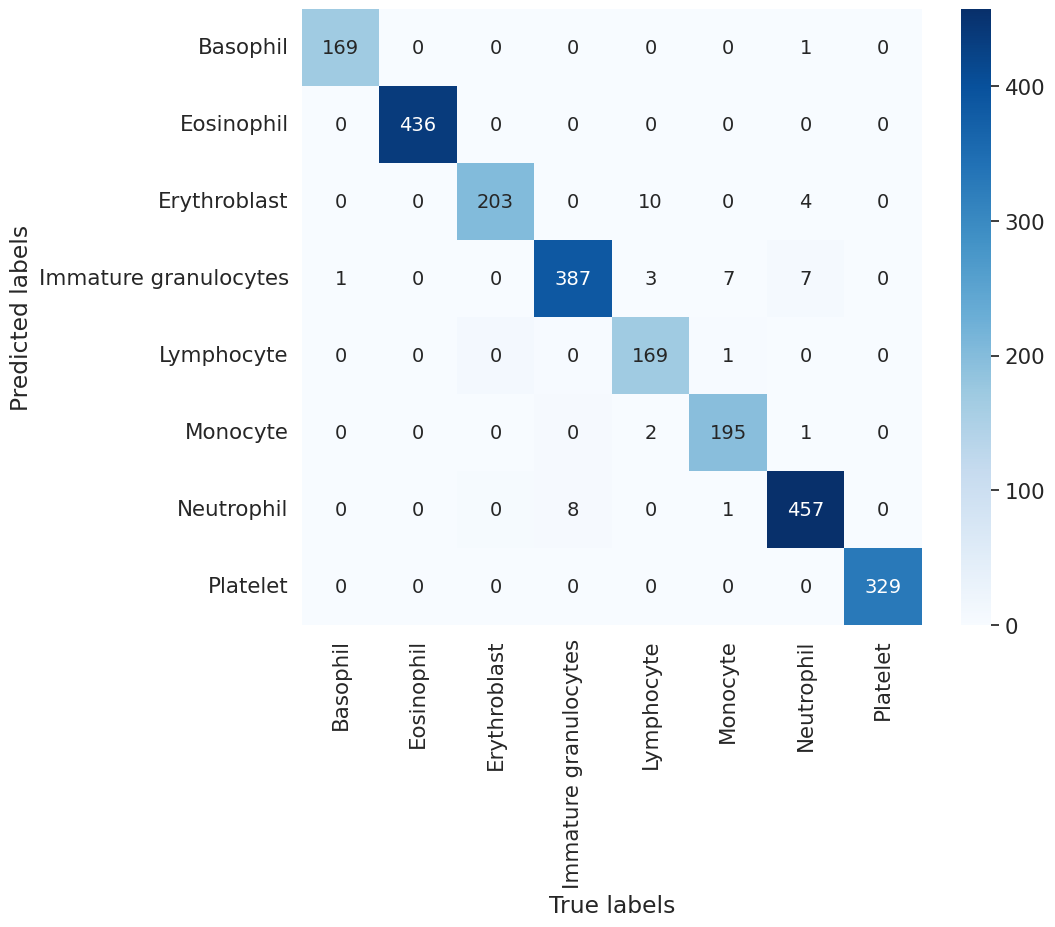

In [ ]:
# Predict labels for the entire test set
predictions1 = ft_model1.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes1 = np.argmax(predictions1, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy1 = accuracy_score(true_classes, pred_classes1)
print(f'Accuracy 1 score over the test set: {round(accuracy1, 4)}')

# Calculate and display test set precision
precision1 = precision_score(true_classes, pred_classes1, average='weighted')
print(f'Precision 1 score over the test set: {round(precision1, 4)}')

# Calculate and display test set recall
recall1 = recall_score(true_classes, pred_classes1, average='weighted')
print(f'Recall score 1 over the test set: {round(recall1, 4)}')

# Calculate and display test set F1 score
f11 = f1_score(true_classes, pred_classes1, average='weighted')
print(f'F1 score 1 over the test set: {round(f11, 4)}')

# Compute the confusion matrix
cm1 = confusion_matrix(true_classes, pred_classes1)

# Combine numbers and percentages into a single string for annotation
annot1 = np.array([f"{num}" for num in cm1.flatten()]).reshape(cm1.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1.T, annot=annot1, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 2 score over the test set: 0.9703
Precision 2 score over the test set: 0.9709
Recall score 2 over the test set: 0.9703
F1 score 2 over the test set: 0.9704


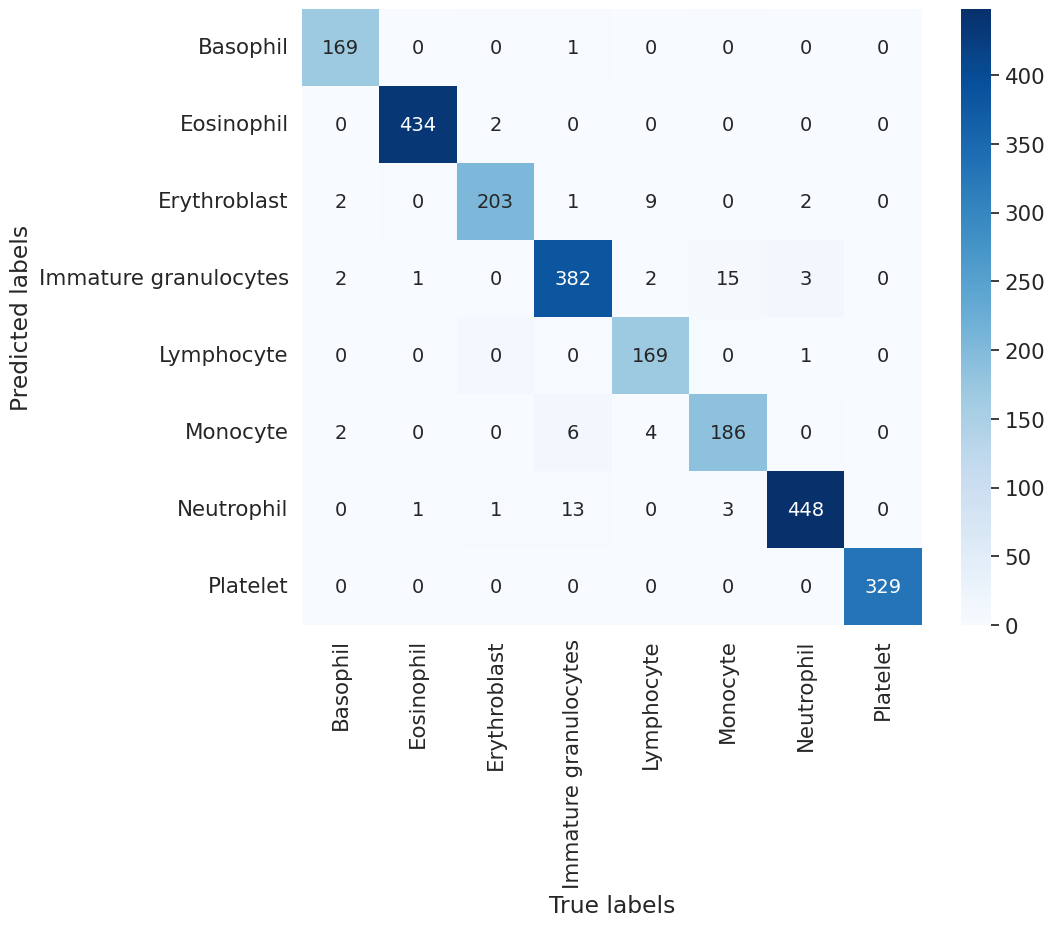

In [ ]:
# Predict labels for the entire test set
predictions2 = ft_model2.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes2 = np.argmax(predictions2, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy2 = accuracy_score(true_classes, pred_classes2)
print(f'Accuracy 2 score over the test set: {round(accuracy2, 4)}')

# Calculate and display test set precision
precision2 = precision_score(true_classes, pred_classes2, average='weighted')
print(f'Precision 2 score over the test set: {round(precision2, 4)}')

# Calculate and display test set recall
recall2 = recall_score(true_classes, pred_classes2, average='weighted')
print(f'Recall score 2 over the test set: {round(recall2, 4)}')

# Calculate and display test set F1 score
f12 = f1_score(true_classes, pred_classes2, average='weighted')
print(f'F1 score 2 over the test set: {round(f12, 4)}')

# Compute the confusion matrix
cm2 = confusion_matrix(true_classes, pred_classes2)

# Combine numbers and percentages into a single string for annotation
annot2 = np.array([f"{num}" for num in cm2.flatten()]).reshape(cm2.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm2.T, annot=annot2, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 3 score over the test set: 0.9803
Precision 3 score over the test set: 0.9808
Recall score 3 over the test set: 0.9803
F1 score 3 over the test set: 0.9803


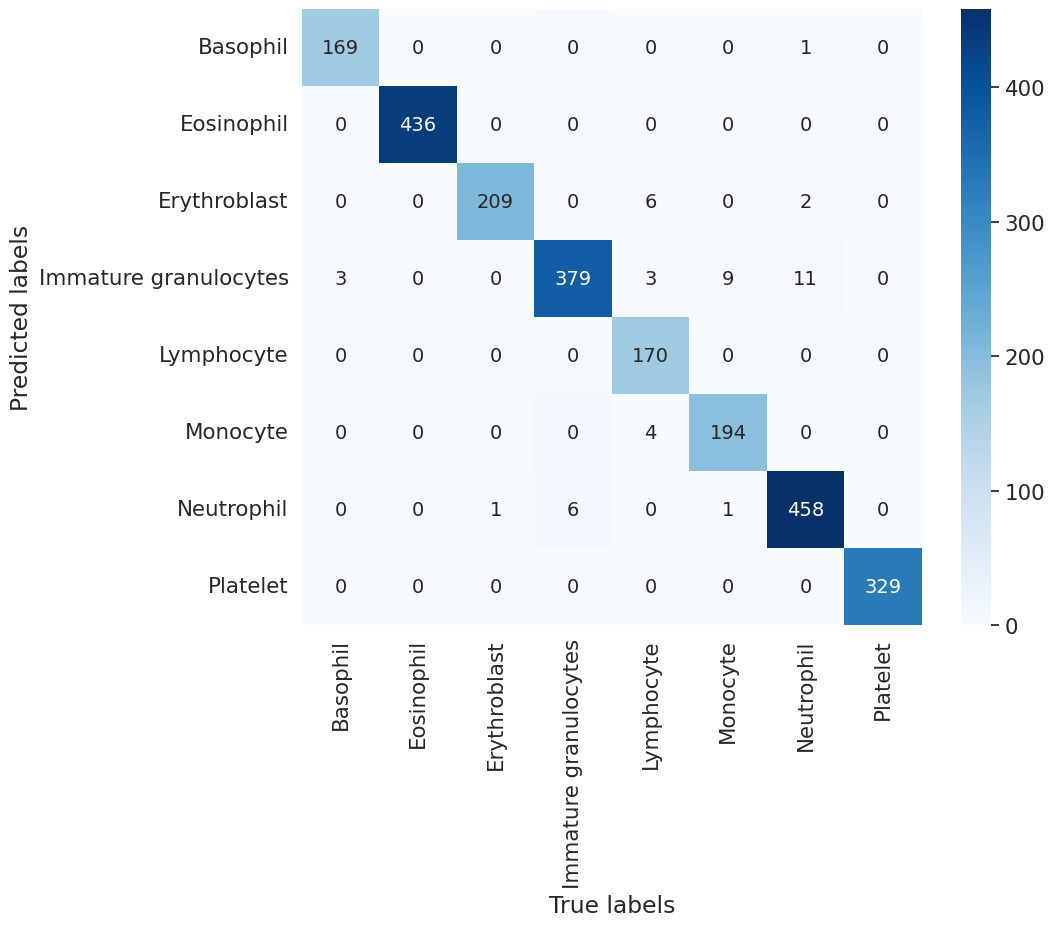

In [ ]:
# Predict labels for the entire test set
predictions3 = ft_model3.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes3 = np.argmax(predictions3, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy3 = accuracy_score(true_classes, pred_classes3)
print(f'Accuracy 3 score over the test set: {round(accuracy3, 4)}')

# Calculate and display test set precision
precision3 = precision_score(true_classes, pred_classes3, average='weighted')
print(f'Precision 3 score over the test set: {round(precision3, 4)}')

# Calculate and display test set recall
recall3 = recall_score(true_classes, pred_classes3, average='weighted')
print(f'Recall score 3 over the test set: {round(recall3, 4)}')

# Calculate and display test set F1 score
f13 = f1_score(true_classes, pred_classes3, average='weighted')
print(f'F1 score 3 over the test set: {round(f13, 4)}')

# Compute the confusion matrix
cm3 = confusion_matrix(true_classes, pred_classes3)

# Combine numbers and percentages into a single string for annotation
annot3 = np.array([f"{num}" for num in cm3.flatten()]).reshape(cm3.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm3.T, annot=annot3, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 2. Test set with augmentation

Accuracy 1 score over the test set augmented: 0.8001
Precision 1 score over the test set augmented: 0.8058
Recall score 1 over the test set augmented: 0.8001
F1 score 1 over the test set augmented: 0.7992


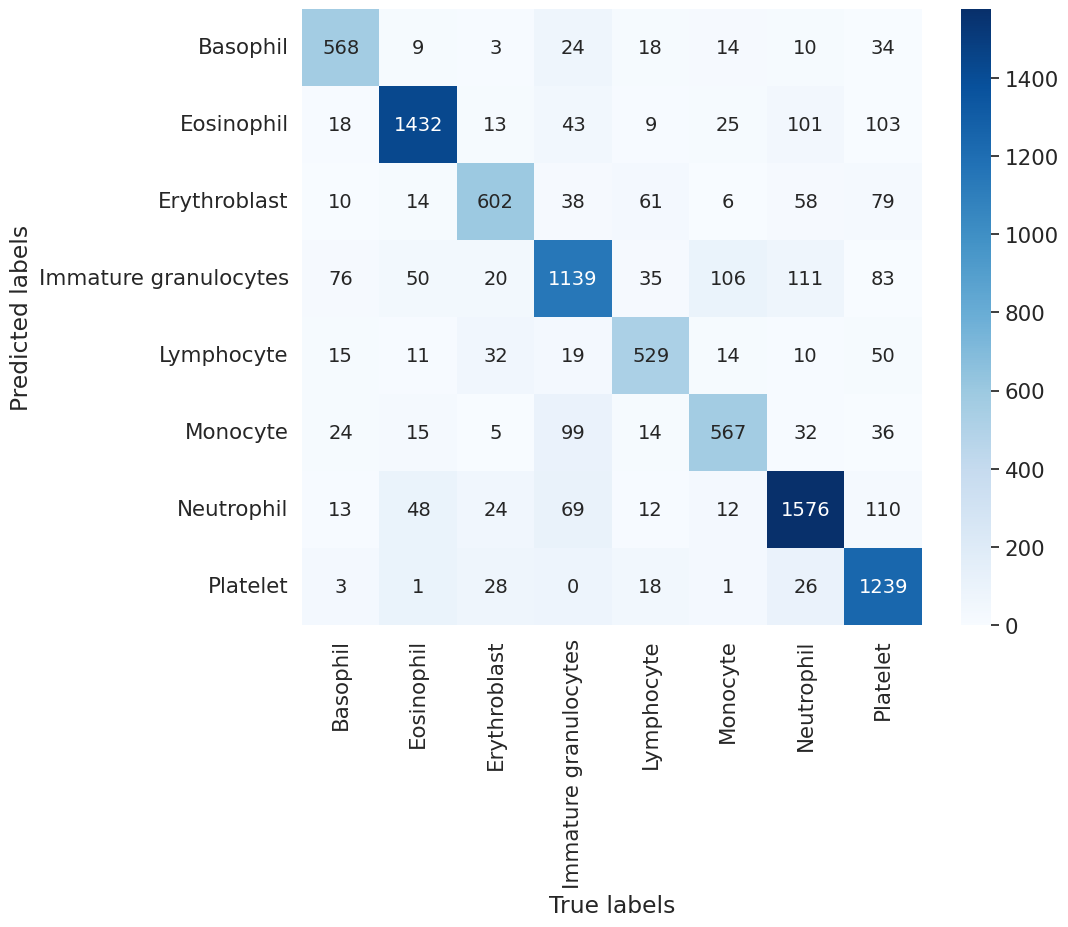

In [ ]:
# Predict labels for the entire test set
predictions1_aug = ft_model1.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes1_aug = np.argmax(predictions1_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy1_aug = accuracy_score(true_classes_aug, pred_classes1_aug)
print(f'Accuracy 1 score over the test set augmented: {round(accuracy1_aug, 4)}')

# Calculate and display test set precision
precision1_aug = precision_score(true_classes_aug, pred_classes1_aug, average='weighted')
print(f'Precision 1 score over the test set augmented: {round(precision1_aug, 4)}')

# Calculate and display test set recall
recall1_aug = recall_score(true_classes_aug, pred_classes1_aug, average='weighted')
print(f'Recall score 1 over the test set augmented: {round(recall1_aug, 4)}')

# Calculate and display test set F1 score
f11_aug = f1_score(true_classes_aug, pred_classes1_aug, average='weighted')
print(f'F1 score 1 over the test set augmented: {round(f11_aug, 4)}')

# Compute the confusion matrix
cm1_aug = confusion_matrix(true_classes_aug, pred_classes1_aug)

# Combine numbers and percentages into a single string for annotation
annot1_aug = np.array([f"{num}" for num in cm1_aug.flatten()]).reshape(cm1_aug.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1_aug.T, annot=annot1_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 2 score over the test set augmented: 0.7157
Precision 2 score over the test set augmented: 0.723
Recall score 2 over the test set augmented: 0.7157
F1 score 2 over the test set augmented: 0.7155


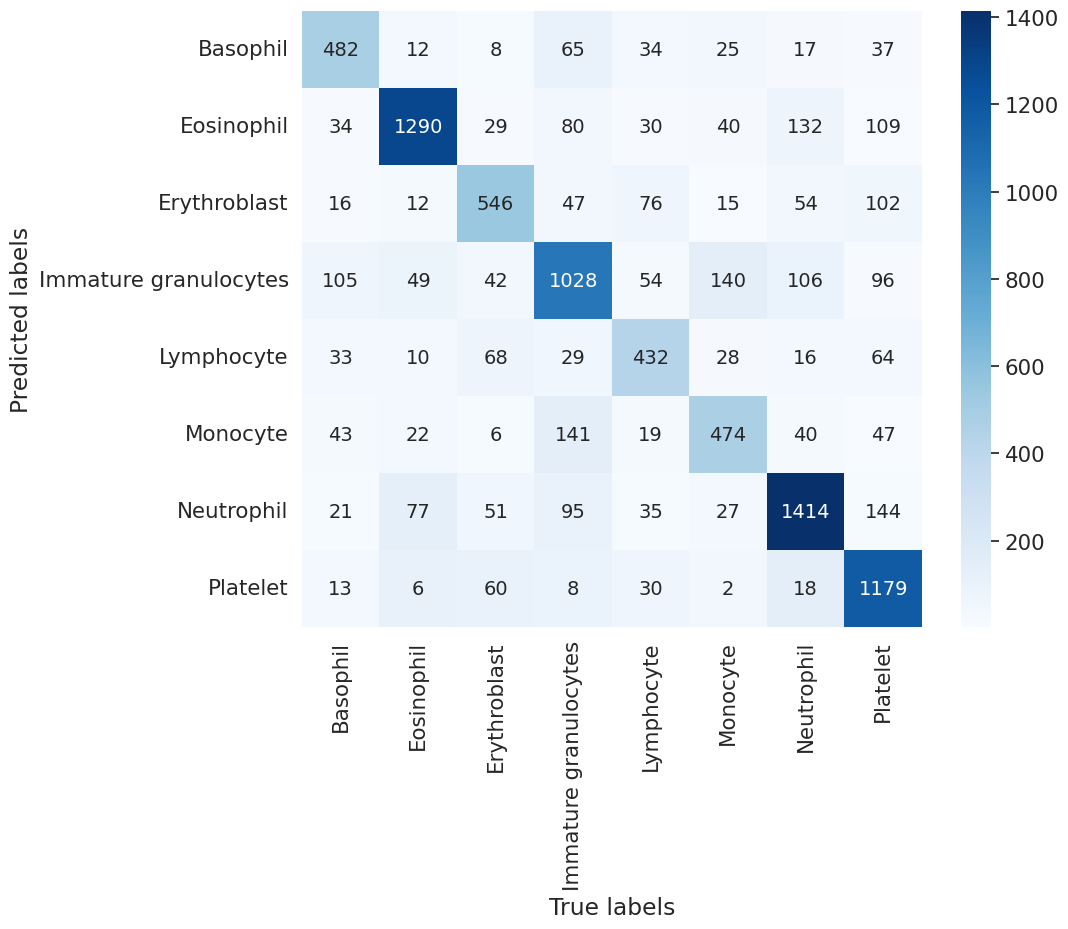

In [ ]:
# Predict labels for the entire test set
predictions2_aug = ft_model2.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes2_aug = np.argmax(predictions2_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy2_aug = accuracy_score(true_classes_aug, pred_classes2_aug)
print(f'Accuracy 2 score over the test set augmented: {round(accuracy2_aug, 4)}')

# Calculate and display test set precision
precision2_aug = precision_score(true_classes_aug, pred_classes2_aug, average='weighted')
print(f'Precision 2 score over the test set augmented: {round(precision2_aug, 4)}')

# Calculate and display test set recall
recall2_aug = recall_score(true_classes_aug, pred_classes2_aug, average='weighted')
print(f'Recall score 2 over the test set augmented: {round(recall2_aug, 4)}')

# Calculate and display test set F1 score
f12_aug = f1_score(true_classes_aug, pred_classes2_aug, average='weighted')
print(f'F1 score 2 over the test set augmented: {round(f12_aug, 4)}')

# Compute the confusion matrix
cm2_aug = confusion_matrix(true_classes_aug, pred_classes2_aug)

# Combine numbers and percentages into a single string for annotation
annot2_aug = np.array([f"{num}" for num in cm2_aug.flatten()]).reshape(cm2_aug.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm2_aug.T, annot=annot2_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 3 score over the test set augmented: 0.7961
Precision 3 score over the test set augmented: 0.8034
Recall score 3 over the test set augmented: 0.7961
F1 score 3 over the test set augmented: 0.7953


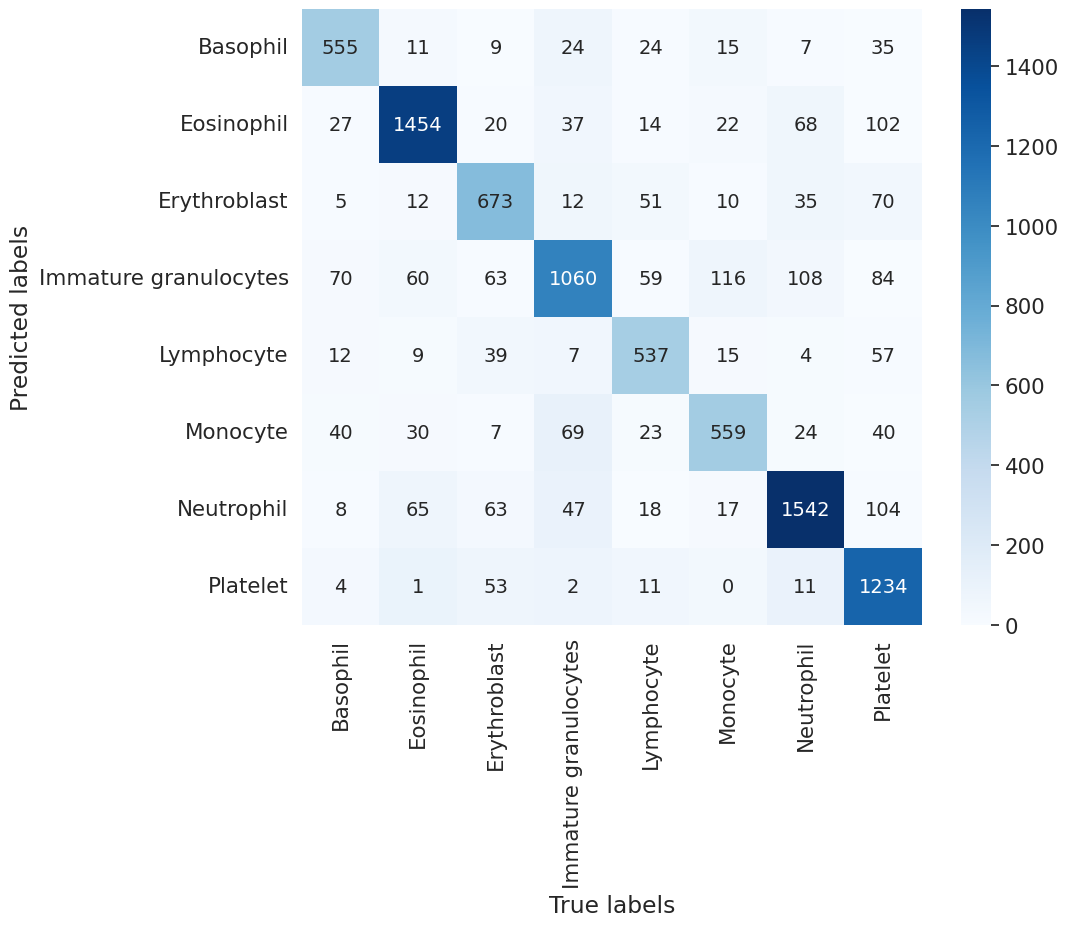

In [ ]:
# Predict labels for the entire test set
predictions3_aug = ft_model3.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes3_aug = np.argmax(predictions3_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy3_aug = accuracy_score(true_classes_aug, pred_classes3_aug)
print(f'Accuracy 3 score over the test set augmented: {round(accuracy3_aug, 4)}')

# Calculate and display test set precision
precision3_aug = precision_score(true_classes_aug, pred_classes3_aug, average='weighted')
print(f'Precision 3 score over the test set augmented: {round(precision3_aug, 4)}')

# Calculate and display test set recall
recall3_aug = recall_score(true_classes_aug, pred_classes3_aug, average='weighted')
print(f'Recall score 3 over the test set augmented: {round(recall3_aug, 4)}')

# Calculate and display test set F1 score
f13_aug = f1_score(true_classes_aug, pred_classes3_aug, average='weighted')
print(f'F1 score 3 over the test set augmented: {round(f13_aug, 4)}')

# Compute the confusion matrix
cm3_aug = confusion_matrix(true_classes_aug, pred_classes3_aug)

# Combine numbers and percentages into a single string for annotation
annot3_aug = np.array([f"{num}" for num in cm3_aug.flatten()]).reshape(cm3_aug.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm3_aug.T, annot=annot3_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python

# file: model.py

import tensorflow as tf
import numpy as np

class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

        # Load the pre-trained model weights
        self.model = tf.keras.models.load_model('weights.keras')  # Path to your saved weights

    def predict(self, X):
        """
        Return a numpy array with the labels corresponding to the input X.
        X: numpy array of input images.
        """
        predictions = self.model.predict(X)
        # Return the class labels as a numpy array
        return np.argmax(predictions, axis=-1)

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        """
        # Load the specific model file
        self.neural_network = tfk.models.load_model('ConvNeXtBase1_FTfull_91.38.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        This function returns class labels as integers.
        """
        # Get predictions and convert to label format
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py ConvNeXtBase1_FTfull_91.38.keras

  adding: model.py (deflated 52%)
  adding: ConvNeXtBase1_FTfull_91.38.keras (deflated 6%)
